#### Importing packages:

In [1]:
from __future__ import print_function, division
from PyAstronomy import pyasl
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from astropy.convolution import convolve
import scipy
np.warnings.filterwarnings('ignore')

Reading in the data and adjusting the txt file:

In [2]:
df = pd.read_csv("xx03",delim_whitespace=True)
df = df.rename_axis("sourceId 57500450000") # Renaming axis for better visualisation
df = df.rename(columns= {"sourceId": "wavelength", "57500450000": "flux"})
print(df)

                      wavelength     flux
sourceId 57500450000                     
0                        840.000  47622.0
1                        840.001  47622.0
2                        840.002  47622.0
3                        840.003  47622.0
4                        840.004  47622.0
...                          ...      ...
49996                    889.996  41082.0
49997                    889.997  41198.0
49998                    889.998  41379.0
49999                    889.999  41595.0
50000                    890.000  41816.0

[50001 rows x 2 columns]


Plotting data (full resolution of 0.001nm):

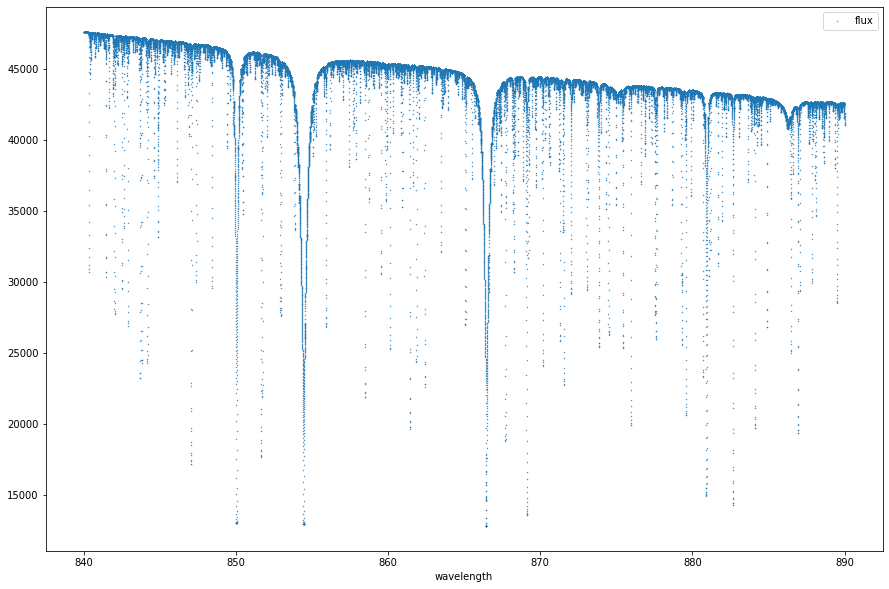

In [3]:
df.plot(style='.',x='wavelength',y='flux',ms=0.8, figsize=(15,10))
plt.show()
# syntheic template

Creating templates:

In [4]:
# Template wavelength and flux
tw = df['wavelength']
tf = df['flux']

# Template 2 (same as sample template)
dw = df['wavelength']
dfl = df['flux']

The relationship between the FWHM and Gaussian sigma:

In [5]:
sig_rvs=(860.5/11500.)/2.35482 # 2.35.. conversion
#FWHM - 11500 is resolution: relation between FWHM and sigma of Gaussian

---

From here onwards, this follows normspec.pro file translated from IDL to Python:

In [6]:
n = df['flux'].size

In [7]:
x1 = 25
x2 = n-1-25

In [8]:
y1 = np.median(df['flux'][0:51])
y2 = np.median(df['flux'][-51:-1])

In [9]:
a = tf[0] #In Python, first term is from index 0


In [10]:
grad = (y2-y1)/(x2-x1)

In [11]:
linear_flux = np.zeros((n),float) # Array of zeros

For loop: for every index in a range from 0 to n-1, linear flux follows the equation stated:

In [12]:
for i in range(0,n-1):
    linear_flux[i] = a + (grad*i)

I am guessing this next line normalises the flux array:

In [13]:
norm_flux_array = tf/linear_flux

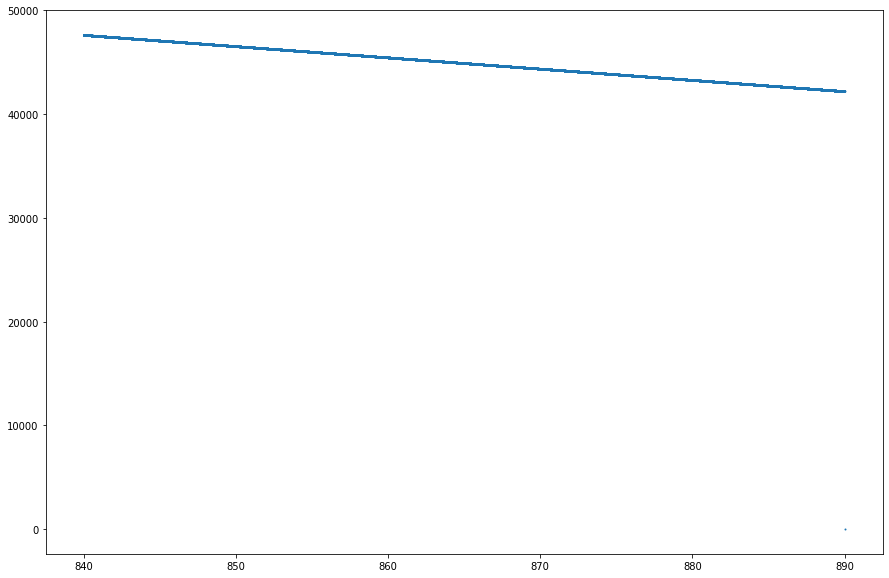

In [14]:
plt.figure(figsize=(15,10))
plt.scatter(tw, linear_flux, s=1) # Gradient
plt.show()

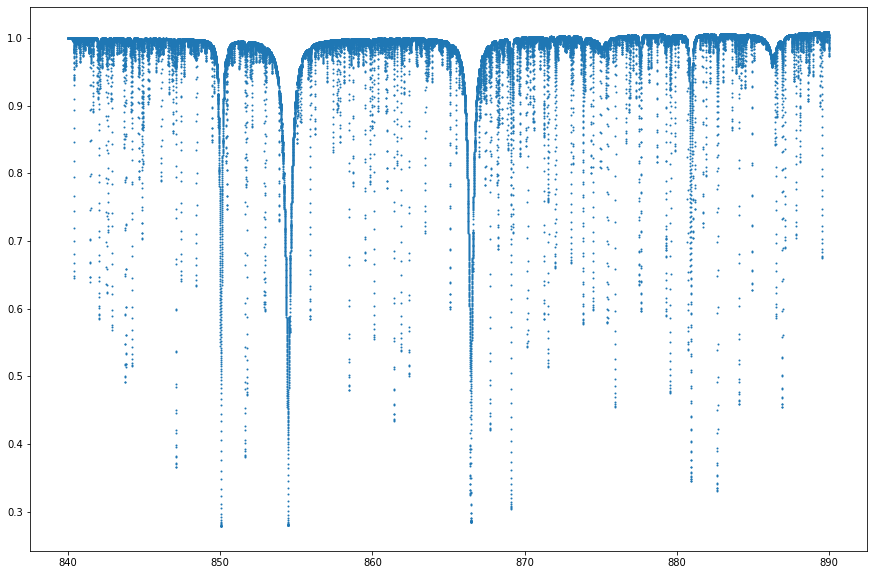

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(tw, norm_flux_array, s=1)
plt.show()

Continuum normalisation. Approximating to original data.
- Trying to compare absorption lines relative to template. 
- If continuum is more sloped in parts than other, parts not always treated equally.

---

#### Convolving with a Gaussian LSF

In [16]:
gauss1d = scipy.ndimage.gaussian_filter1d(df['flux'],sig_rvs)

Revised for new range - variables with _rev indicate the revised range:

In [17]:
n_rev = gauss1d.size
y1_rev = np.median(gauss1d[0:51])
y2_rev = np.median(gauss1d[-51:-1])
a_rev = gauss1d[0]
grad_rev = (y2-y1)/(x2-x1)

Normalised flux for Gaussian convolution:

In [18]:
norm_flux_array2 = gauss1d/linear_flux

Appending norm_flux_array2 to dataframe:

In [19]:
df['norm_flux_array'] = norm_flux_array2

Selecting range from dataframe between 846-870nm:

In [20]:
norm_rvs_range = df['norm_flux_array'][(df['wavelength'] >= 846.0) & (df['wavelength'] < 870.0)]
tw_rvs_range = df['wavelength'][(df['wavelength'] >= 846.0) & (df['wavelength'] < 870.0)]

Plot  original range vs revised range:

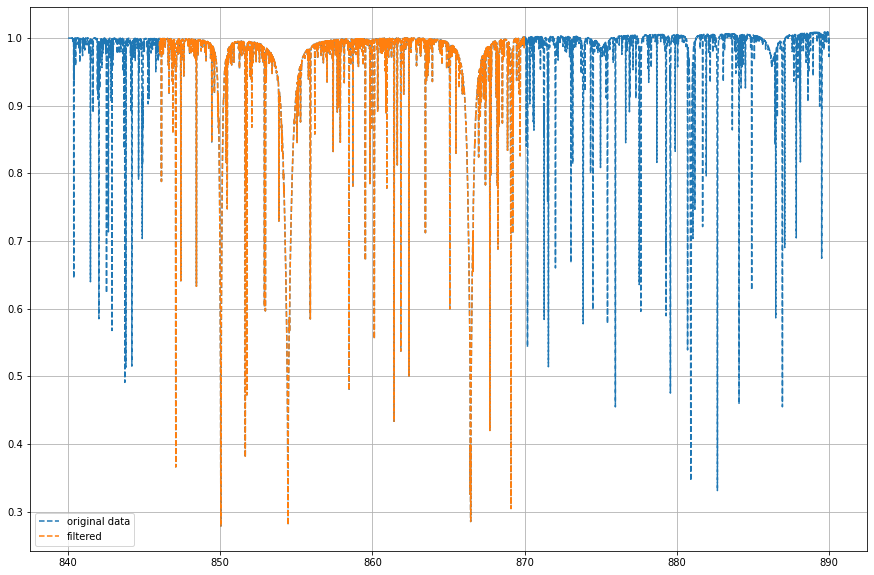

In [21]:
plt.figure(figsize=(15,10))
plt.plot(tw, norm_flux_array2, '--', label='original data')
plt.plot(tw_rvs_range,norm_rvs_range, '--', label='filtered')
plt.legend()
plt.grid()
plt.show()

normalised convolved gaussian of flux for range 846-870nm wavelength

---

Resampling the spectra to obtain RVS-like resolution:

In [22]:
import spectres
rvs_obs = np.arange(846,870,0.025)
rvs_template = np.arange(840,890,0.025)

In [23]:
import sys
np.set_printoptions(threshold=sys.maxsize)

Getting resampled fluxes:

In [24]:
rvs_flux = spectres.spectres(rvs_obs,tw.values, norm_flux_array2)
template_flux = spectres.spectres(rvs_template,tw.values, norm_flux_array2)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



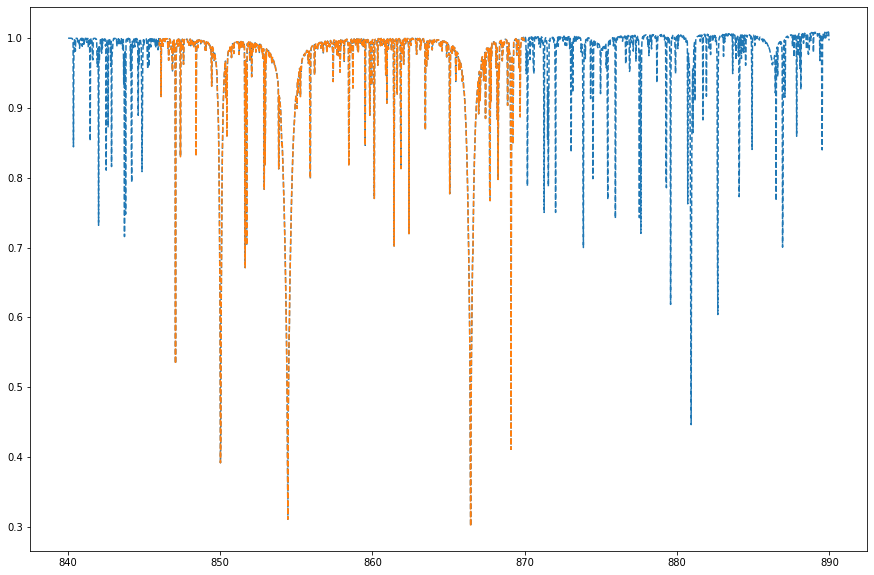

In [25]:
plt.figure(figsize=(15,10))
plt.plot(rvs_template,template_flux, '--')
plt.plot(rvs_obs,rvs_flux,'--')
plt.show()

---

#### Cross Correlation

The sizes of the orginal data were:

In [26]:
print(len(tw))
print(len(norm_flux_array2))

50001
50001


where the resolution here is 0.001nm. Resampling to have an RVS-like spectra resolution, we have data sizes of:

In [27]:
print(len(rvs_obs))
print(len(rvs_flux))

960
960


The Python function for Cross Correlation (with adjustements to the final cross correlation function). Original source code for the cross correlation function can be found at https://github.com/sczesla/PyAstronomy.

In [28]:
# import numpy as np
# from PyAstronomy.pyaC import pyaErrors as PE
# from PyAstronomy.pyasl import _ic


# def crosscorrRV(w, f, tw, tf, rvmin, rvmax, drv, mode="doppler", skipedge=0, edgeTapering=None):
#     if not _ic.check["scipy"]:
#         raise (PE.PyARequiredImport("This routine needs scipy (.interpolate.interp1d).", \
#                                     where="crosscorrRV", \
#                                     solution="Install scipy"))
#     import scipy.interpolate as sci
#     # Copy and cut wavelength and flux arrays
#     w, f = w.copy(), f.copy()
#     if skipedge > 0:
#         w, f = w[skipedge:-skipedge], f[skipedge:-skipedge]

#     if edgeTapering is not None:
#         # Smooth the edges using a sine
#         if isinstance(edgeTapering, float):
#             edgeTapering = [edgeTapering, edgeTapering]
#         if len(edgeTapering) != 2:
#             raise (PE.PyAValError("'edgeTapering' must be a float or a list of two floats.", \
#                                   where="crosscorrRV"))
#         if edgeTapering[0] < 0.0 or edgeTapering[1] < 0.0:
#             raise (PE.PyAValError("'edgeTapering' must be (a) number(s) >= 0.0.", \
#                                   where="crosscorrRV"))
#         # Carry out edge tapering (left edge)
#         indi = np.where(w < w[0] + edgeTapering[0])[0]
#         f[indi] *= np.sin((w[indi] - w[0]) / edgeTapering[0] * np.pi / 2.0)
#         # Carry out edge tapering (right edge)
#         indi = np.where(w > (w[-1] - edgeTapering[1]))[0]
#         f[indi] *= np.sin((w[indi] - w[indi[0]]) / edgeTapering[1] * np.pi / 2.0 + np.pi / 2.0)

#     # Speed of light in km/s
#     c = 299792.458
#     # Check order of rvmin and rvmax
#     if rvmax <= rvmin:
#         raise (PE.PyAValError("rvmin needs to be smaller than rvmax.",
#                               where="crosscorrRV", \
#                               solution="Change the order of the parameters."))
#     # Check whether template is large enough
#     if mode == "lin":
#         meanWl = np.mean(w)
#         dwlmax = meanWl * (rvmax / c)
#         dwlmin = meanWl * (rvmin / c)
#         if (tw[0] + dwlmax) > w[0]:
#             raise (PE.PyAValError("The minimum wavelength is not covered by the template for all indicated RV shifts.", \
#                                   where="crosscorrRV", \
#                                   solution=["Provide a larger template", "Try to use skipedge"]))
#         if (tw[-1] + dwlmin) < w[-1]:
#             raise (PE.PyAValError("The maximum wavelength is not covered by the template for all indicated RV shifts.", \
#                                   where="crosscorrRV", \
#                                   solution=["Provide a larger template", "Try to use skipedge"]))
#     elif mode == "doppler":
#         # Ensure that the template covers the entire observation for all shifts
#         maxwl = tw[-1] * (1.0 + rvmin / c)
#         minwl = tw[0] * (1.0 + rvmax / c)
#         if minwl > w[0]:
#             raise (PE.PyAValError("The minimum wavelength is not covered by the template for all indicated RV shifts.", \
#                                   where="crosscorrRV", \
#                                   solution=["Provide a larger template", "Try to use skipedge"]))
#         if maxwl < w[-1]:
#             raise (PE.PyAValError("The maximum wavelength is not covered by the template for all indicated RV shifts.", \
#                                   where="crosscorrRV", \
#                                   solution=["Provide a larger template", "Try to use skipedge"]))
#     else:
#         raise (PE.PyAValError("Unknown mode: " + str(mode), \
#                               where="crosscorrRV", \
#                               solution="See documentation for available modes."))
#     # Calculate the cross correlation
#     drvs = np.arange(rvmin, rvmax, drv)
#     cc = np.zeros(len(drvs))
#     for i, rv in enumerate(drvs):
#         if mode == "lin":
#             # Shift the template linearly
#             fi = sci.interp1d(tw + meanWl * (rv / c), tf)
#         elif mode == "doppler":
#             # Apply the Doppler shift
#             fi = sci.interp1d(tw * (1.0 + rv / c), tf)
#         # Shifted template evaluated at location of spectrum
#         cc[i] = np.sum((f - (np.mean(f))) * (fi(w) - (np.mean(fi(w)))))/np.sqrt((np.sum((f - np.mean(f))**2)) * (np.sum((fi(w)-np.mean(fi(w)))**2)))
    
#     return drvs, cc

In [29]:
%run -i 'Cross Correlation Function.py'

In [30]:
rv, cc = crosscorrRV(rvs_obs,rvs_flux,rvs_template,template_flux,-1000.,1000.,1.,mode='doppler',skipedge=0)

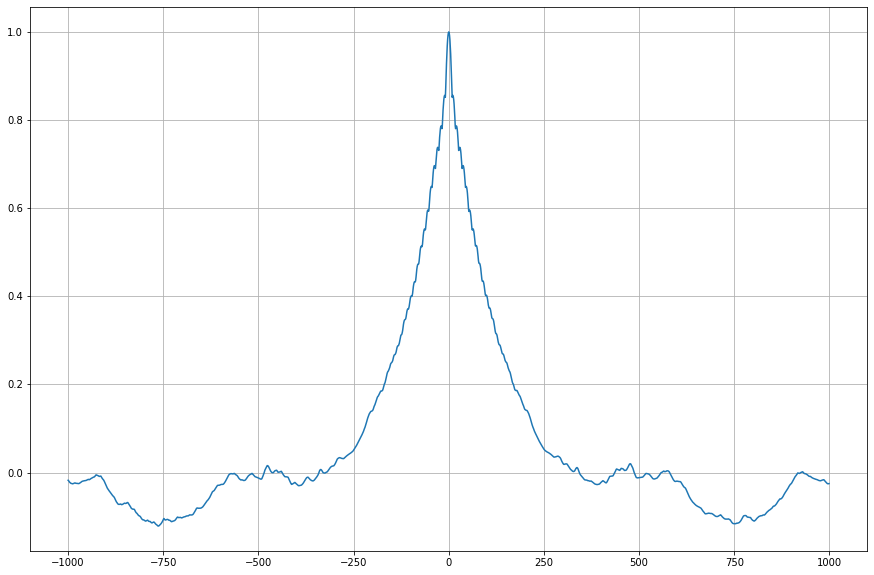

In [31]:
plt.figure(figsize=(15,10))
plt.plot(rv,cc)
plt.grid()
plt.show()